In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (119 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define some functions

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import matplotlib.patches as patches
import random
import cv2
import openslide

In [4]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def get_images(lst, slide, tumor_mask):
  for i in lst:
    slide_path = '/content/drive/My Drive/slide/Copy of tumor_{}.tif'.format(i)
    mask_path = '/content/drive/My Drive/slide/Copy of tumor_{}_mask.tif'.format(i)
    slide_image = open_slide(slide_path)
    mask_image = open_slide(mask_path)
    slide.append(slide_image)
    tumor_mask.append(mask_image)

  return slide, tumor_mask

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def tissue_pixels_percentage(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    tissue_pixels = list(zip(indices[0], indices[1]))
    percentage = len(tissue_pixels) / float(image.shape[0] * image.shape[0])
    return percentage


def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [5]:
def checkcancer(mask, start, end, off):
  midx = midy = (start + end) // 2

  x_lower, x_upper = midx - off//2, midx + off//2
  y_lower, y_upper = midy - off//2, midy + off//2

  # Check is the 128 X 128 region contain cancer cell
  p = np.sum(mask[x_lower: x_upper, y_lower : y_upper])
 
  return p > 100

def plot_images(slide_image, mask_image):
    offset = 64
    fig, axes = plt.subplots(1,2, figsize=(7,7))
    midx = midy = 299 // 2
    a = axes[0]
    a.set_title("image")
    a.imshow(slide_image)

    a = axes[1]
    a.set_title('masked image ')
    a.imshow(slide_image)
    a.imshow(mask_image, cmap='jet', alpha=0.5)  
    # plot a 128 X 128 square detect region
    a.plot([midx - offset, midx - offset, midx + offset, midx + offset,midx - offset ],
                [midy - offset, midy + offset, midy + offset, midy - offset, midy - offset], 'g')

In [6]:
def sliding_windows(picture,  level_num, patch_size, mask_picture):
  # parameters
  downsize_factor =pow(2, level_num)
  True_slide_images, True_slide_mask = [], []
  False_slide_images = []
  tissue_regions = []

  slide = picture
  mask = mask_picture
  offset = 64
  row = slide.level_dimensions[level_num][0]
  col = slide.level_dimensions[level_num][1]
  
  # sliding windows
  for i in range(0, col - patch_size, patch_size):
    y_start = i
 
    
    for j in range(0, row - patch_size, patch_size):
      x_start = j
      #print(x_start, y_start)
      #image slide
      
      slide_image = read_slide(slide, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
    # mask slide
      mask_image = read_slide(mask, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
      # masks used on image
      if tissue_pixels_percentage(slide_image) < 0.2:
        continue

      mask_image_verify = mask_image[:,:,0]

      label = checkcancer(mask_image_verify, 0, 299, 128)

      #collection True data and False data
      if label:
        True_slide_images.append(slide_image)
        True_slide_mask.append(mask_image_verify)

      else:
        False_slide_images.append(slide_image)
        
     


      # visualize
      #plot_images(slide_image, mask_image_verify, level_num )
      # if contain cancer, zoom out and collection image
        

      
  return True_slide_images, False_slide_images, True_slide_mask

In [7]:
def collectionimage(picture,  level_num, patch_size, mask_picture):
  # parameters
  downsize_factor =pow(2, level_num)
  True_slide_images, True_slide_mask = [], []
  False_slide_images = []
  y_actual = []
  x_test = []

  slide = picture
  mask = mask_picture
  offset = 64
  row = slide.level_dimensions[level_num][0]
  col = slide.level_dimensions[level_num][1]
  
  # sliding windows
  for i in range(0, col - patch_size, patch_size):
    y_start = i
 
    
    for j in range(0, row - patch_size, patch_size):
      x_start = j
      #print(x_start, y_start)
      #image slide
      
      slide_image = read_slide(slide, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
    # mask slide
      mask_image = read_slide(mask, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
      # masks used on image
      mask_image_verify = mask_image[:,:,0]

      label = checkcancer(mask_image_verify, 0, 299, 128)
      if tissue_pixels_percentage(slide_image) < 0.2:
        continue
      #collection True data and False data
      if label:
        True_slide_images.append(slide_image * 64./255)
        True_slide_mask.append(mask_image_verify)
        y_actual.append('True')
      else:
        False_slide_images.append(slide_image * 64./255)
        y_actual.append('False')
      
      x_test.append(slide_image * 64./255)
     


      # visualize
      #plot_images(slide_image, mask_image_verify, level_num )
      # if contain cancer, zoom out and collection image
        

      
  return True_slide_images, False_slide_images, True_slide_mask, x_test, y_actual

In [8]:
def heatmap(picture,  level_num, patch_size, mask_array, mask_picture):
  # parameters
  downsize_factor =pow(2, level_num)
  slide = picture
  offset = 64
  mask_copy = mask_array.copy()
  mask = mask_picture
  res = []
  row = slide.level_dimensions[level_num][0]
  col = slide.level_dimensions[level_num][1]
  # sliding windows
  for i in range(0, col - patch_size, patch_size):
    y_start = i
    for j in range(0, row - patch_size, patch_size):
      x_start = j
      #print(x_start, y_start)
      #image slide
      slide_image = read_slide(slide, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)  # mask slide

      m_image = read_slide(mask, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
      # masks used on image
      if tissue_pixels_percentage(slide_image) < 0.2:
        continue
      mask_image_verify = m_image[:,:,0]

      label = checkcancer(mask_image_verify, 0, 299, 128)
      # masks used on image
      im_batch = tf.expand_dims(slide_image, axis=0)
      result = model.predict(im_batch)
      idx = np.argmax(result, axis = 1)
      result = markers[int(idx)]
      #print(result)
      #print(label)
      if result == 'True':
        mask_copy[i : i+299, j : j + 299] = 1
      if result == 'False':
        mask_copy[i : i+299, j : j + 299] = 0
      

        

      
  return mask_copy

## Collect Training datas

In [9]:
image_list = ['091','101','078','075', '064'] 
level_array = [3,4,5, 6]

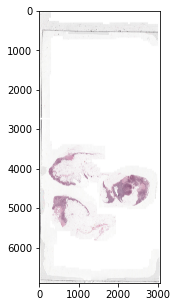

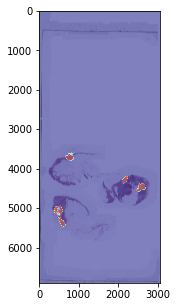

In [10]:
slides, tumor_masks = get_images(['064'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [12]:
True_64_image = []
False_64_image = []
True_64_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_64_image += True_data 
  False_64_image += False_data
  True_64_mask += True_mask

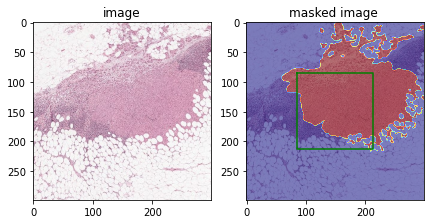

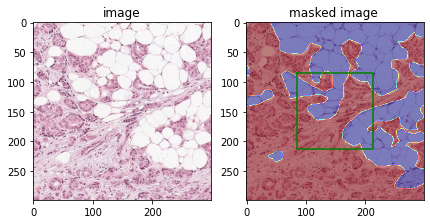

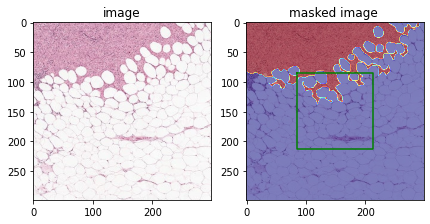

In [13]:
for i in range(3):
  n = random.randint(0, len(True_64_image) - 1)
  plot_images(True_64_image[n], True_64_mask[n])

In [ ]:
random.shuffle(True_64_image)
random.shuffle(False_64_image)
Train_true_image, validation_true_image = True_64_image[len(True_64_image)//3 :], True_64_image[: len(True_64_image)//3]
Train_false_image, validation_false_image = False_64_image[len(False_64_image)//3:], False_64_image[: len(False_64_image)//3]

In [ ]:
#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell2/Test/True/image64_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

#for i in range(len(validation_true_image)):
#  True_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/True/image64_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(True_X_Validation_filename,validation_true_image[i])

#for i in range(len(Train_false_image)):
#  False_X_train_filename = '/content/drive/My Drive/Cell2/Test/False/image64_{}.png'.format(i)
#  plt.imshow(Train_false_image[i])
#  cv2.imwrite(False_X_train_filename,Train_false_image[i])



#for i in range(len(validation_false_image)):
#  False_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/False/image64_{}.png'.format(i)
#  plt.imshow(validation_false_image[i])
#  cv2.imwrite(False_X_Validation_filename,validation_false_image[i])

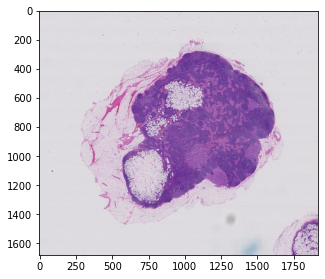

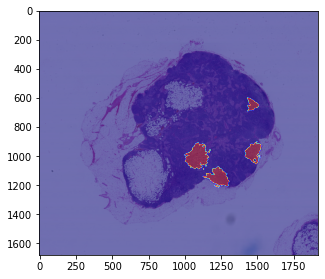

In [ ]:
slides, tumor_masks = get_images(['091'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_91_image = []
False_91_image = []
True_91_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_91_image += True_data 
  False_91_image += False_data
  True_91_mask += True_mask

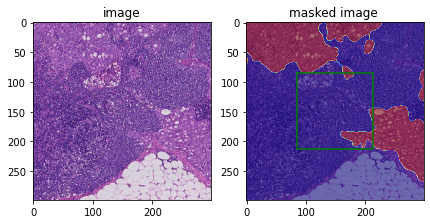

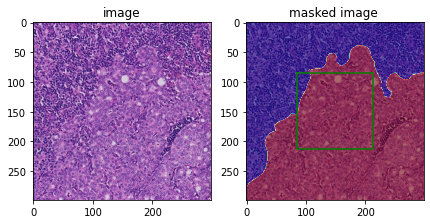

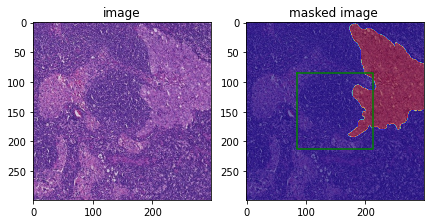

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_91_image) - 1)
  plot_images(True_91_image[n], True_91_mask[n])

In [ ]:
random.shuffle(True_91_image)
random.shuffle(False_91_image)
Train_true_image, validation_true_image = True_91_image[len(True_91_image)//3 :], True_91_image[: len(True_91_image)//3]
Train_false_image, validation_false_image = False_91_image[len(False_91_image)//3:], False_91_image[: len(False_91_image)//3]

In [ ]:
#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell2/Test/True/image91_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

In [ ]:
#for i in range(len(validation_true_image)):
#  True_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/True/image91_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(True_X_Validation_filename,validation_true_image[i])

In [ ]:
#for i in range(len(Train_false_image)):
#  False_X_train_filename = '/content/drive/My Drive/Cell2/Test/False/image91_{}.png'.format(i)
#  plt.imshow(Train_false_image[i])
#  cv2.imwrite(False_X_train_filename,Train_false_image[i])



#for i in range(len(validation_false_image)):
#  False_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/False/image91_{}.png'.format(i)
#  plt.imshow(validation_false_image[i])
#  cv2.imwrite(False_X_Validation_filename,validation_false_image[i])

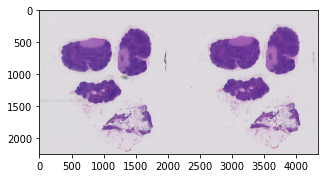

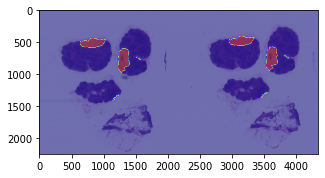

In [ ]:
slides, tumor_masks = get_images(['101'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_101_image = []
False_101_image = []
True_101_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_101_image += True_data 
  False_101_image += False_data
  True_101_mask += True_mask

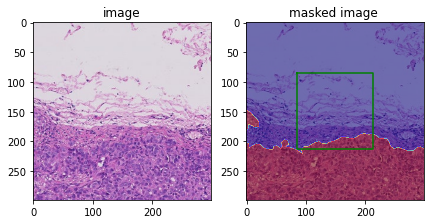

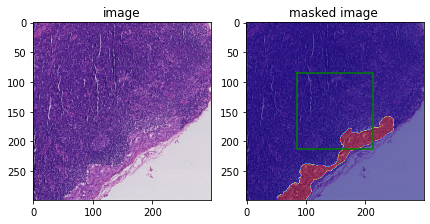

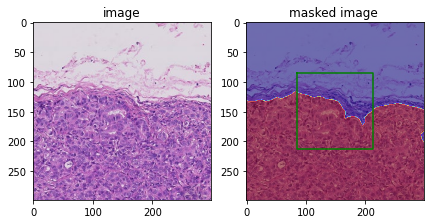

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_101_image) - 1)
  plot_images(True_101_image[n], True_101_mask[n])

In [ ]:
random.shuffle(True_101_image)
random.shuffle(False_101_image)
Train_true_image, validation_true_image = True_101_image[len(True_101_image)//3 :], True_101_image[: len(True_101_image)//3]
Train_false_image, validation_false_image = False_101_image[len(False_101_image)//3:], False_101_image[:len(False_101_image)//3]

In [ ]:

#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell2/Test/True/image101_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

#for i in range(len(validation_true_image)):
#  True_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/True/image101_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(True_X_Validation_filename,validation_true_image[i])

#for i in range(len(Train_false_image)):
#  False_X_train_filename = '/content/drive/My Drive/Cell2/Test/False/image101_{}.png'.format(i)
#  plt.imshow(Train_false_image[i])
#  cv2.imwrite(False_X_train_filename,Train_false_image[i])



#for i in range(len(validation_false_image)):
#  False_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/False/image101_{}.png'.format(i)
#  plt.imshow(validation_false_image[i])
#  cv2.imwrite(False_X_Validation_filename,validation_false_image[i])

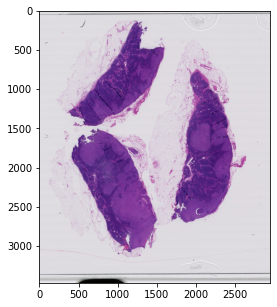

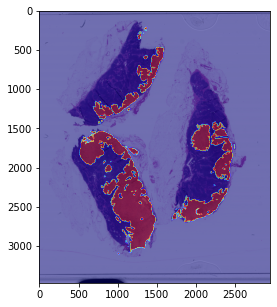

In [ ]:
slides, tumor_masks = get_images(['078'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_078_image = []
False_078_image = []
True_078_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_078_image += True_data 
  False_078_image += False_data
  True_078_mask += True_mask

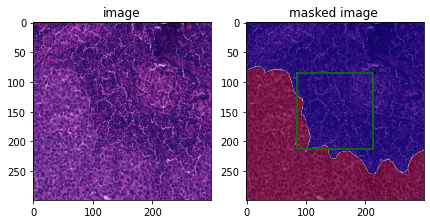

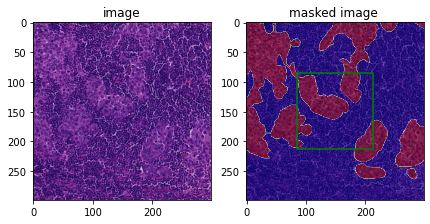

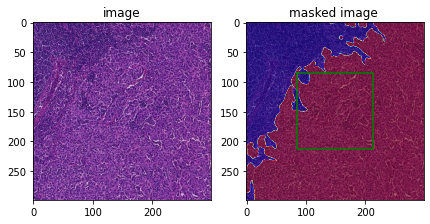

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_078_image) - 1)
  plot_images(True_078_image[n], True_078_mask[n])

In [ ]:
random.shuffle(True_078_image)
random.shuffle(False_078_image)
Train_true_image, validation_true_image = True_078_image[len(True_078_image)//3 :], True_078_image[: len(True_078_image)//3]
Train_false_image, validation_false_image = False_078_image[len(False_078_image)//3:], False_078_image[:len(False_078_image)//3]

In [ ]:
#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell2/Test/True/image78_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

#for i in range(len(validation_true_image)):
#  True_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/True/image78_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(True_X_Validation_filename,validation_true_image[i])

#for i in range(len(Train_false_image)):
#  False_X_train_filename = '/content/drive/My Drive/Cell2/Test/False/image78_{}.png'.format(i)
#  plt.imshow(Train_false_image[i])
#  cv2.imwrite(False_X_train_filename,Train_false_image[i])


#
#for i in range(len(validation_false_image)):
#  False_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/False/image78_{}.png'.format(i)
#  plt.imshow(validation_false_image[i])
#  cv2.imwrite(False_X_Validation_filename,validation_false_image[i])

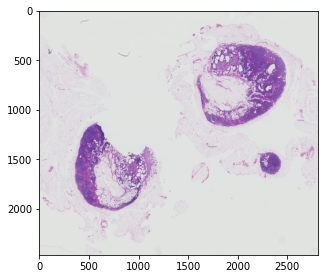

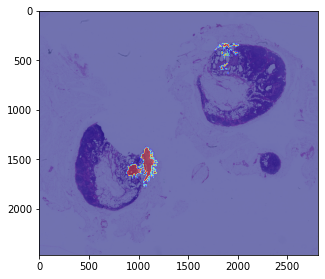

In [ ]:
slides, tumor_masks = get_images(['075'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_75_image = []
False_75_image = []
True_75_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_75_image += True_data 
  False_75_image += False_data
  True_75_mask += True_mask

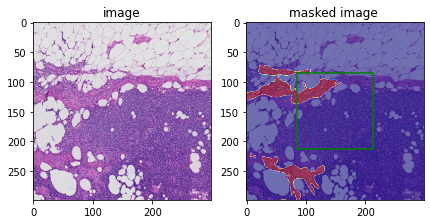

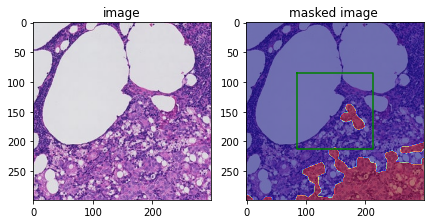

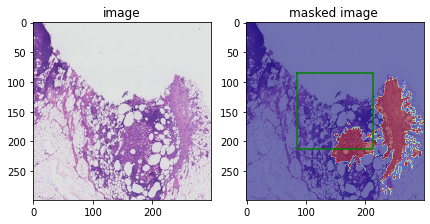

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_75_image) - 1)
  plot_images(True_75_image[n], True_75_mask[n])

In [ ]:
random.shuffle(True_75_image)
random.shuffle(False_75_image)
Train_true_image, validation_true_image = True_75_image[len(True_75_image)//3 :], True_75_image[ : len(True_75_image)//3]
Train_false_image, validation_false_image = False_75_image[len(False_75_image)//3:], False_75_image[:len(False_75_image)//3]

In [ ]:
#for i in range(len(Train_true_image)):
##  True_X_train_filename = '/content/drive/My Drive/Cell2/Test/True/image75_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

#for i in range(len(validation_true_image)):
#  True_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/True/image75_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(True_X_Validation_filename,validation_true_image[i])

#for i in range(len(Train_false_image)):
#  False_X_train_filename = '/content/drive/My Drive/Cell2/Test/False/image75_{}.png'.format(i)
#  plt.imshow(Train_false_image[i])
#  cv2.imwrite(False_X_train_filename,Train_false_image[i])



#for i in range(len(validation_false_image)):
#  False_X_Validation_filename = '/content/drive/My Drive/Cell2/Validation/False/image75_{}.png'.format(i)
#  plt.imshow(validation_false_image[i])
#  cv2.imwrite(False_X_Validation_filename,validation_false_image[i])

## Training Models, both self_created model and InceptionV3

In [ ]:
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras import preprocessing
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dir = '/content/drive/My Drive/Cell2/Test'
valid_dir = '/content/drive/My Drive/Cell2/Validation'
markers = ['False', 'True']

train_datagen = ImageDataGenerator(
    rescale=64./255,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=64./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32 ,
    shuffle=True)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True)

Found 2299 images belonging to 2 classes.
Found 1064 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    #print(labels_batch)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32, 2)


In [ ]:
conv_base = tf.keras.applications.InceptionV3(weights='imagenet',
                  include_top=False, input_shape = (299, 299, 3))

model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

conv_base.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


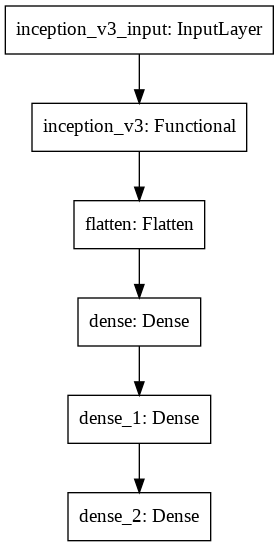

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(
      train_generator,
      epochs=5,
      validation_data = validation_generator)

Epoch 1/5
72/72 [==============================] - 20s 281ms/step - loss: 2.0829 - acc: 0.7999 - val_loss: 2.2432 - val_acc: 0.6278
Epoch 2/5
72/72 [==============================] - 19s 269ms/step - loss: 1.0473 - acc: 0.8530 - val_loss: 1.0836 - val_acc: 0.8191
Epoch 3/5
72/72 [==============================] - 19s 264ms/step - loss: 0.5502 - acc: 0.8960 - val_loss: 0.5785 - val_acc: 0.8813
Epoch 4/5
72/72 [==============================] - 19s 267ms/step - loss: 0.1798 - acc: 0.9526 - val_loss: 0.5278 - val_acc: 0.8794
Epoch 5/5
72/72 [==============================] - 19s 266ms/step - loss: 0.1353 - acc: 0.9569 - val_loss: 0.6385 - val_acc: 0.8880


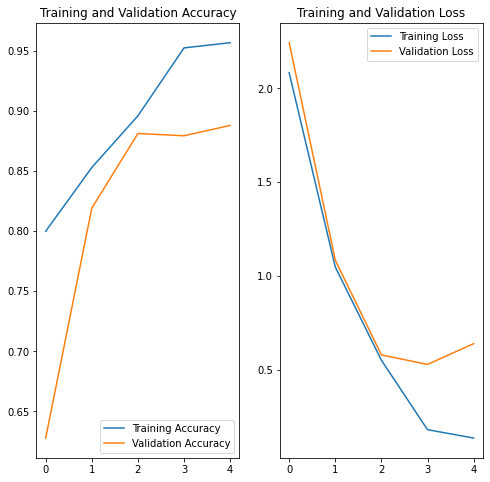

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Mymodel = models.Sequential()
Mymodel.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(299, 299, 3)))
Mymodel.add(layers.MaxPooling2D((2, 2)))
Mymodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
Mymodel.add(layers.MaxPooling2D((2, 2)))
Mymodel.add(layers.Conv2D(512, (3, 3), activation='relu'))
Mymodel.add(layers.MaxPooling2D((2, 2)))
Mymodel.add(layers.Conv2D(512, (3, 3), activation='relu'))
Mymodel.add(layers.MaxPooling2D((2, 2)))
Mymodel.add(layers.Flatten())
Mymodel.add(layers.Dropout(0.1))
Mymodel.add(layers.Dense(128, activation='relu'))
Mymodel.add(layers.Dense(2, activation='softmax'))

Mymodel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = Mymodel.fit(
      train_generator,
      epochs=5,
      validation_data = validation_generator)

Epoch 1/5
72/72 [==============================] - 23s 321ms/step - loss: 17.7587 - acc: 0.7033 - val_loss: 0.4920 - val_acc: 0.8124
Epoch 2/5
72/72 [==============================] - 23s 318ms/step - loss: 0.5226 - acc: 0.7538 - val_loss: 0.3401 - val_acc: 0.8785
Epoch 3/5
72/72 [==============================] - 23s 316ms/step - loss: 0.3849 - acc: 0.8347 - val_loss: 0.2844 - val_acc: 0.9033
Epoch 4/5
72/72 [==============================] - 23s 316ms/step - loss: 0.3487 - acc: 0.8578 - val_loss: 0.3453 - val_acc: 0.8727
Epoch 5/5
72/72 [==============================] - 23s 318ms/step - loss: 0.3142 - acc: 0.8808 - val_loss: 0.2476 - val_acc: 0.9072


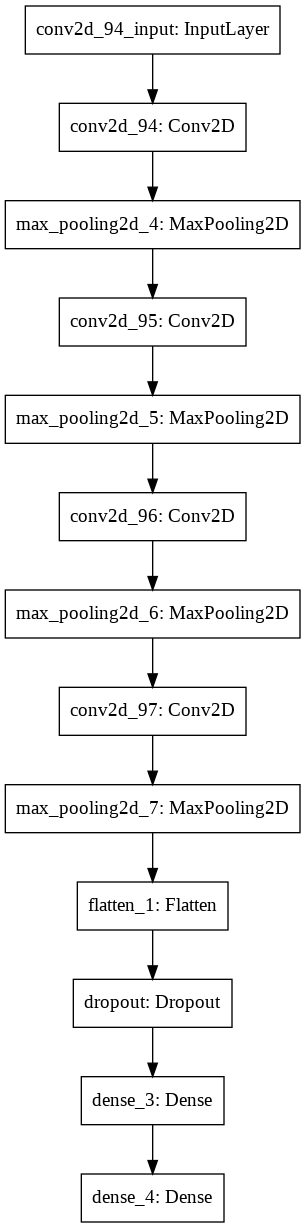

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(Mymodel, to_file='model.png')

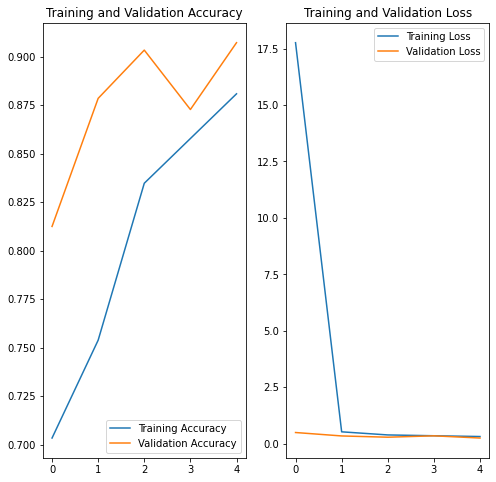

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Reproducing Heatmap and Precision / recall


In [ ]:
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from sklearn.metrics import confusion_matrix
import pandas as pd

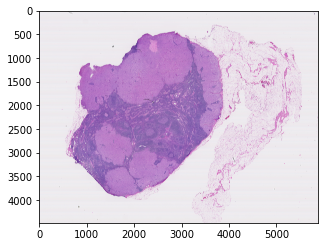

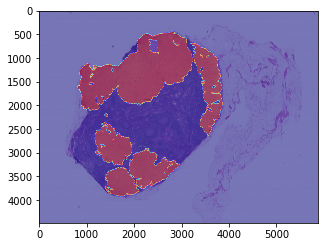

In [ ]:
slides, tumor_masks = get_images(['110'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slides[i].level_dimensions[4][0], 
                         height=slides[i].level_dimensions[4][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=4, 
                        width=slides[i].level_dimensions[4][0], 
                        height=slides[i].level_dimensions[4][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

True_110_image = []
False_110_image = []
True_110_mask = []

for i in [4]:
  True_data, False_data, True_mask, x_test, y_actual = collectionimage(slides[0], i, 299, tumor_masks[0])
  True_110_image += True_data 
  False_110_image += False_data
  True_110_mask += True_mask

In [ ]:
predict_true = []
for image in True_110_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_true.append(markers[int(idx)])

predict_false = []
for image in False_110_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_false.append(markers[int(idx)])
  
True_matrix = ['True'] * len(predict_true)
False_matrix = ['False'] * len(predict_false)
actual = True_matrix + False_matrix
predict = predict_true + predict_false
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predict, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
TP = df_confusion.iloc[1][1] 
FP = df_confusion.iloc[0][1] 
FN = df_confusion.iloc[1][0]
NP = df_confusion.iloc[0][0]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
accuracy = (TP + NP) / (TP + FP + FN + NP)
print('The Precision of that model is:', round(Precision, 2))
print('The Recall of that model is:', round(Recall, 2))
print('The Accuracy of that model is:', round(accuracy, 2))

The Precision of that model is: 0.96
The Recall of that model is: 0.8
The Accuracy of that model is: 0.86


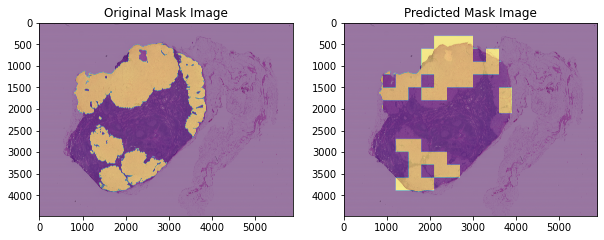

In [ ]:
for i in [4]:
  res = heatmap(slides[0], i, 299, mask_image, tumor_masks[0])

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(slide_image)
plt.imshow(mask_image, alpha=0.5)
plt.title('Original Mask Image')

plt.subplot(1, 2, 2)
plt.imshow(slide_image)
plt.imshow(res, alpha=0.5)
plt.title('Predicted Mask Image')
plt.show()

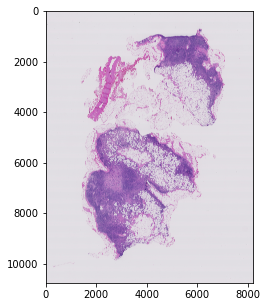

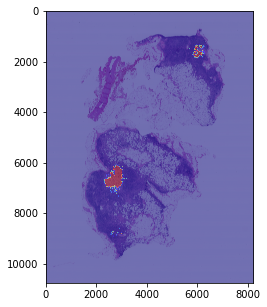

In [ ]:
slides, tumor_masks = get_images(['084'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slides[i].level_dimensions[3][0], 
                         height=slides[i].level_dimensions[3][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slides[i].level_dimensions[3][0], 
                        height=slides[i].level_dimensions[3][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

True_084_image = []
False_084_image = []
True_084_mask = []

for i in [4]:
  True_data, False_data, True_mask, x_test, y_actual = collectionimage(slides[0], i, 299, tumor_masks[0])
  True_084_image += True_data 
  False_084_image += False_data
  True_084_mask += True_mask

In [ ]:
predict_true = []
for image in True_084_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_true.append(markers[int(idx)])

predict_false = []
for image in False_084_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_false.append(markers[int(idx)])
  
True_matrix = ['True'] * len(predict_true)
False_matrix = ['False'] * len(predict_false)
actual = True_matrix + False_matrix
predict = predict_true + predict_false
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predict, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
TP = df_confusion.iloc[1][1] 
FP = df_confusion.iloc[0][1] 
FN = df_confusion.iloc[1][0]
NP = df_confusion.iloc[0][0]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
accuracy = (TP + NP) / (TP + FP + FN + NP)
print('The Precision of that model is:', round(Precision, 2))
print('The Recall of that model is:', round(Recall, 2))
print('The Accuracy of that model is:', round(accuracy, 2))

The Precision of that model is: 0.83
The Recall of that model is: 0.45
The Accuracy of that model is: 0.96


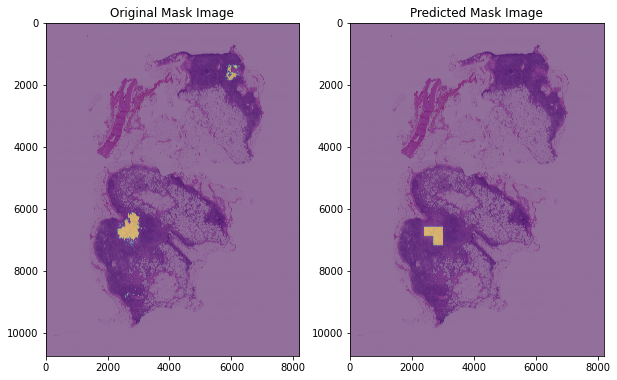

In [ ]:
for i in [4]:
  res = heatmap(slides[0], i, 299, mask_image, tumor_masks[0])

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(slide_image)
plt.imshow(mask_image, alpha=0.5)
plt.title('Original Mask Image')

plt.subplot(1, 2, 2)
plt.imshow(slide_image)
plt.imshow(res, alpha=0.5)
plt.title('Predicted Mask Image')
plt.show()

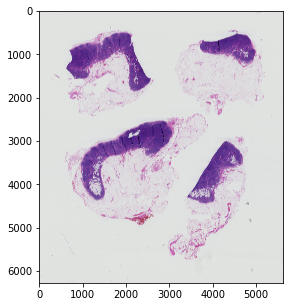

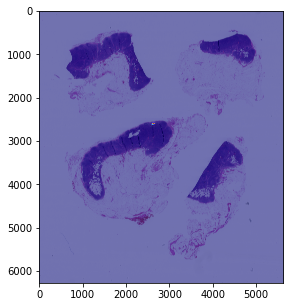

In [ ]:
slides, tumor_masks = get_images(['081'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slides[i].level_dimensions[4][0], 
                         height=slides[i].level_dimensions[4][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=4, 
                        width=slides[i].level_dimensions[4][0], 
                        height=slides[i].level_dimensions[4][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

True_081_image = []
False_081_image = []
True_081_mask = []

for i in [4]:
  True_data, False_data, True_mask, x_test, y_actual = collectionimage(slides[0], i, 299, tumor_masks[0])
  True_081_image += True_data 
  False_081_image += False_data
  True_081_mask += True_mask

In [ ]:
predict_true = []
for image in True_081_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_true.append(markers[int(idx)])

predict_false = []
for image in False_081_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_false.append(markers[int(idx)])
  
True_matrix = ['True'] * len(predict_true)
False_matrix = ['False'] * len(predict_false)

actual = True_matrix + False_matrix
predict = predict_true + predict_false
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predict, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
TP = df_confusion.iloc[1][1] 
FP = df_confusion.iloc[0][1] 
FN = df_confusion.iloc[1][0]
NP = df_confusion.iloc[0][0]
Precision = TP / (TP + 0)
Recall = TP / (TP + FN)
accuracy = (TP + NP) / (TP + FP + FN + NP)
print('The Precision of that model is:', round(Precision, 2))
print('The Recall of that model is:', round(Recall, 2))
print('The Accuracy of that model is:', round(accuracy, 2))

The Precision of that model is: 1.0
The Recall of that model is: 1.0
The Accuracy of that model is: 1.0


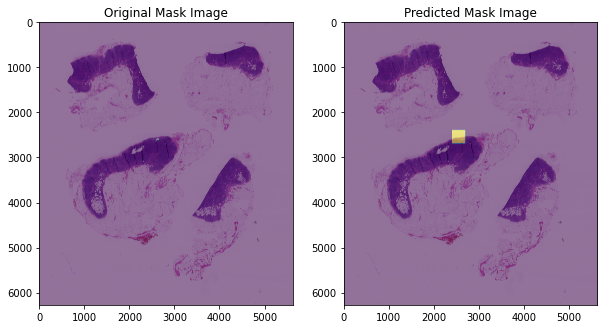

In [ ]:
for i in [4]:
  res = heatmap(slides[0], i, 299, mask_image, tumor_masks[0])

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(slide_image)
plt.imshow(mask_image, alpha=0.5)
plt.title('Original Mask Image')

plt.subplot(1, 2, 2)
plt.imshow(slide_image)
plt.imshow(res, alpha=0.5)
plt.title('Predicted Mask Image')
plt.show()